### Libraries Needed

In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
from scipy.optimize import brentq
import math
from pytz import UTC

# Implied volatility

Extracting local volatility is crucial for modeling the dynamics of financial assets. Local volatility models allow the asset's volatility to vary with both price and time, providing a more accurate representation than constant volatility models.

To begin, we'll need to gather market data, including historical prices of options, spot prices, risk-free interest rates, and dividends. Using this data, we can construct the implied volatility surface, which displays implied volatility for various strike prices and maturities.

In [242]:
def recup_strike(ticker, end_date):
    start_date = end_date - timedelta(days=90)
    data = yf.download(ticker, start=start_date, end=end_date,progress=False)
    data['Returns'] = data['Adj Close'].pct_change().dropna()
    returns = data['Returns'].dropna()
    historical_volatility = np.std(returns) * np.sqrt(252)
    return data['Adj Close'].iloc[-1], historical_volatility

def option_chains(ticker):
    asset = yf.Ticker(ticker)
    expirations = asset.options
    chains = pd.DataFrame()
    for expiration in expirations:
        opt = asset.option_chain(expiration)
        calls = opt.calls
        calls['optionType'] = "call"
        puts = opt.puts
        puts['optionType'] = "put"
        chain = pd.concat([calls, puts])
        chain['expiration'] = pd.to_datetime(expiration) + pd.DateOffset(hours=23, minutes=59, seconds=59)
        chains = pd.concat([chains, chain])
        
    chains['lastTradeDate'] = pd.to_datetime(chains['lastTradeDate']).dt.tz_convert(None)
    chains["TimeToMaturity"] = round(((chains.expiration - chains['lastTradeDate']).dt.days + 1)/365,2)

    return chains


In [418]:
ticker = "MSFT" 
option_data = option_chains(ticker)
last_trade_dates = option_data['lastTradeDate'].unique()

historical_data = {}
for date in last_trade_dates:
    strike, volatility = recup_strike(ticker, date)
    historical_data[date] = (strike, volatility)

option_data['spotPrice'] = option_data['lastTradeDate'].apply(lambda x: historical_data[x][0])
option_data['historicalVolatility'] = option_data['lastTradeDate'].apply(lambda x: historical_data[x][1])

print(option_data[['strike', 'lastPrice', 'spotPrice', 'historicalVolatility', 'TimeToMaturity']])

    strike  lastPrice   spotPrice  historicalVolatility  TimeToMaturity
0    220.0     233.28  446.950012              0.187684            0.02
1    240.0     212.91  446.950012              0.187684            0.02
2    260.0     191.30  446.950012              0.187684            0.02
3    270.0     183.08  446.950012              0.187684            0.02
4    290.0     163.35  446.950012              0.187684            0.02
..     ...        ...         ...                   ...             ...
67   600.0     155.50  449.779999              0.187228            2.50
68   610.0     156.43  452.850006              0.187052            2.48
69   620.0     175.28  445.700012              0.188823            2.50
70   640.0     195.23  445.700012              0.188823            2.50
71   660.0     206.07  452.850006              0.187052            2.48

[2433 rows x 5 columns]


In [419]:
calls = option_data[option_data["optionType"] == "call"]
put = option_data[option_data["optionType"] == "put"]

I noticed that on Yahoo Finance, implied volatilities are provided, but the specific method used to compute them isn't clear to me. To gain a deeper understanding of how implied volatilities are constructed, I've decided to compute them myself. This approach will allow me to delve into well-known financial mathematical formulas and better grasp their application.

To compute implied volatilities accurately, one typically needs to employ numerical methods. These methods aim to find the volatility value that, when input into the Black-Scholes formula, results in the market price of the option. A commonly used approach involves employing root-finding algorithms such as the Newton-Raphson method or Brent's method. I choose to use Brent's method and Bisection's method.

The Black-Scholes formula is foundational in options pricing, serving as a starting point for more sophisticated models that accommodate additional factors such as dividends, early exercise features, and varying interest rates. Its insights into risk-neutral valuation have significantly shaped modern finance.

The Black-Scholes formula Call and Put formula are :
$$
{\boxed{C(S_{0},K,r,T,\sigma )=S_{0}{\mathcal {N}}(d_{1})-K\mathrm {e} ^{-rT}{\mathcal {N}}(d_{2})}}
$$

$$
{\boxed{P(S_{0},K,r,T,\sigma )=-S_{0}{\mathcal {N}}(-d_{1})+K\mathrm {e} ^{-rT}{\mathcal {N}}(-d_{2})}}
$$

with : 
- $\mathcal {N}$ :  la fonction de répartition de la loi normale centrée réduite $\mathcal {N}{(0,1)}$
- $d1 = {\frac {1}{\sigma {\sqrt {T}}}}\left[\ln \left({\frac {S_{0}}{K}}\right)+\left(r+{\frac {1}{2}}\sigma ^{2}\right)T\right]$  
- $d2 = d1-\sigma {\sqrt {T}}$
- $S_0$ the current underlying price
- $K the strike option price
- $r$ the risk-free interest rate
- $T$ the time to maturity of the option
- $\sigma$ the volatility of the underlying asset


In [474]:
def call_bsm(So, K, r, T, sigma):
    d1 = (np.log(So / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return So * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

Brent's method is another root-finding algorithm that combines the robustness of the bisection method with the speed of methods such as secant method, bisection method and inverse quadratic interpolation. It does not require the derivative of the function and generally converges faster than bisection.

Brent's method iteratively narrows down the interval containing the root by:
- <ins>Bisection method</ins> : Given an interval $[a, b]$ where $ f(a) $ and $ f(b) $ have opposite signs (i.e., $ f(a) \cdot f(b) < 0 $), the iterative formula for the bisection method is: $ \boxed{c = \frac{a + b}{2} }$
    - If $ f(c) = 0 $, then $ c $ is the root.
    - If $ f(a) \cdot f(c) < 0 $, then the root lies in $[a, c]$.
    - If $ f(b) \cdot f(c) < 0 $, then the root lies in $[c, b]$.

- <ins>Secant method</ins> : Given two initial guesses $ x_0 $ and $ x_1 $, the iterative formula for the secant method is: $\boxed{ x_{n+1} = x_n - \frac{f(x_n) \cdot (x_n - x_{n-1})}{f(x_n) - f(x_{n-1})} }$
    - $ x_n $ is the current estimate of the root,
    - $ f(x_n) $ and $ f(x_{n-1}) $ are the values of the function at $ x_n $ and $ x_{n-1} $, respectively.

- <ins>Inverse quadratic interpolation</ins> : Given three points $ x_0, x_1, x_2 $ where $ f(x_0), f(x_1), f(x_2) \neq 0 $, the formula for the new approximation $ x_3 $ is:

     $\boxed{ x_3 = x_0 - \frac{2 \left[ (x_0 - x_1)(f(x_0) - f(x_2)) - (x_0 - x_2)(f(x_0) - f(x_1)) \right]}{(x_0 - x_1)^2 (f(x_0) - f(x_2)) - (x_0 - x_2)^2 (f(x_0) - f(x_1))}}$

    - $ x_3 $ is the new approximation of the root,
    - $ x_0, x_1, x_2 $ are three successive points used for interpolation,
    - $ f(x_0), f(x_1), f(x_2) $ are the values of the function evaluated at $ x_0, x_1, x_2 $, respectively.

In [475]:
def implied_vol_objective(sigma, market_price, S, K, T, r):
    return call_bsm(S, K, T, r, sigma) - market_price

In [476]:
market_prices = calls['lastPrice'].values
spot_prices = calls['spotPrice'].values
strikes = calls['strike'].values
times_to_maturity = calls['TimeToMaturity'].values 
risk_free_rate = 0.0436  
historical_volatility = calls['historicalVolatility'].values

vol_lower = 1e-6
vol_upper = 5.0

implied_vols = []

for market_price, S, K, T, hist_vol in zip(market_prices, spot_prices, strikes, times_to_maturity, historical_volatility):
    try:
        implied_volatility = brentq(implied_vol_objective, vol_lower, vol_upper, args=(market_price, S, K, T, risk_free_rate))
    except ValueError:
        implied_volatility = np.nan 
    implied_vols.append(implied_volatility)

for K, iv in zip(strikes, implied_vols):
    print(f"Strike Price: {K}, Implied Volatility: {iv:.4f}")

Strike Price: 220.0, Implied Volatility: 2.4736
Strike Price: 240.0, Implied Volatility: 2.1795
Strike Price: 260.0, Implied Volatility: 1.7913
Strike Price: 270.0, Implied Volatility: 1.8463
Strike Price: 290.0, Implied Volatility: 1.6532
Strike Price: 300.0, Implied Volatility: nan
Strike Price: 310.0, Implied Volatility: nan
Strike Price: 315.0, Implied Volatility: 1.3830
Strike Price: 320.0, Implied Volatility: nan
Strike Price: 325.0, Implied Volatility: 0.6932
Strike Price: 345.0, Implied Volatility: nan
Strike Price: 350.0, Implied Volatility: nan
Strike Price: 355.0, Implied Volatility: nan
Strike Price: 360.0, Implied Volatility: nan
Strike Price: 365.0, Implied Volatility: 0.7070
Strike Price: 370.0, Implied Volatility: nan
Strike Price: 375.0, Implied Volatility: nan
Strike Price: 380.0, Implied Volatility: nan
Strike Price: 385.0, Implied Volatility: nan
Strike Price: 390.0, Implied Volatility: nan
Strike Price: 395.0, Implied Volatility: nan
Strike Price: 400.0, Implied Vo

As you can see the results are not good and after diving into the functions (brentq doc), I didn't find the purpose and decided to continue with Yahoo FInance implied volatilities.

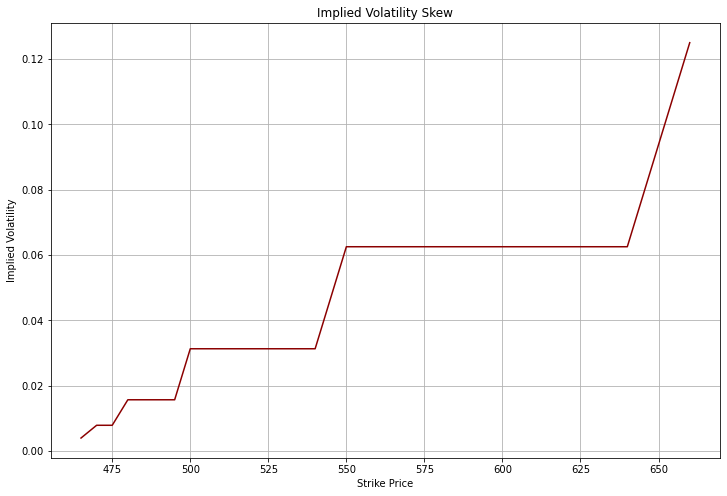

In [477]:
most_common_date=calls['expiration'].mode(0).values[0]
calls_at_expiry = calls[calls["expiration"] == most_common_date].reset_index(drop=True)
calls_at_expiry = calls_at_expiry[calls_at_expiry['impliedVolatility']!=max(calls_at_expiry['impliedVolatility'])]

filtered_calls_at_expiry = calls_at_expiry[calls_at_expiry.impliedVolatility >= 0.0001]

plt.figure(figsize=(12,8))
plt.plot(np.array(filtered_calls_at_expiry["strike"]), np.array(filtered_calls_at_expiry["impliedVolatility"]),color='darkred')
plt.title("Implied Volatility Skew")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.grid(True)
plt.show()

In [478]:
def err_func(So, K, r, T, sigma, market):
    return call_bsm(So, K, r, T, sigma) - market

def implied_vol(So, K, T, r, market, flag, tol=1e-4, max_iterations=10000):
    a = 0.0001
    b = 1
    N = 1
    while N <= max_iterations:
        sg = (a + b) / 2
        N += 1
        error = err_func(So, K, r, T, sg, market)
        if abs(error) < tol or (b - a) / 2 < tol:
            return sg
        elif np.sign(error) == np.sign(err_func(So, K, r, T, a, market)):
            a = sg
        else:
            b = sg
    return None  

implied_vol_df = pd.DataFrame({
    'Strike': np.array(calls['strike']),  
    'TTM': np.array(calls['TimeToMaturity']),
    'market': np.array(calls['lastPrice']),  
    'Spot' : np.array(calls['spotPrice'])
})

r = 0.0436 

implied_vol_df['imp_vol'] = implied_vol_df.apply(lambda row: implied_vol(row['Spot'], row['Strike'], row['TTM'], r, row['market'], "Call"), axis=1)

implied_vol_df['imp_vol'] = implied_vol_df['imp_vol'].round(6)

implied_vol_df = implied_vol_df[implied_vol_df['imp_vol'] != 0.999939]

print(implied_vol_df)


      Strike   TTM  market        Spot   imp_vol
9      325.0  0.10   92.02  414.670013  0.457696
24     415.0  0.01   46.00  460.769989  0.434627
29     430.0  0.01   31.85  460.769989  0.508838
35     445.0  0.01   16.10  460.769989  0.198505
37     450.0  0.01   11.00  460.769989  0.114713
...      ...   ...     ...         ...       ...
1248   600.0  2.46   39.10  460.769989  0.230363
1249   610.0  2.48   37.55  452.850006  0.242935
1250   620.0  2.47   35.70  459.279999  0.235977
1251   640.0  2.47   30.50  459.279999  0.231705
1252   660.0  2.46   26.50  460.769989  0.229020

[961 rows x 5 columns]


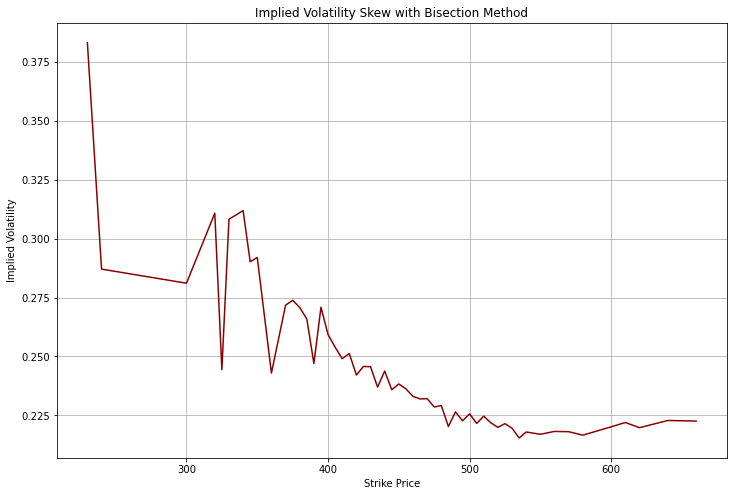

In [479]:
most_common_date=implied_vol_df['TTM'].mode(0).values[0]
calls_at_expiry = implied_vol_df[implied_vol_df["TTM"] == most_common_date].reset_index(drop=True)

filtered_calls_at_expiry = calls_at_expiry[calls_at_expiry.imp_vol >= 0.0001]

plt.figure(figsize=(12,8))
plt.plot(np.array(filtered_calls_at_expiry["Strike"]), np.array(filtered_calls_at_expiry["imp_vol"]),color='darkred')
plt.title("Implied Volatility Skew with Bisection Method")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.grid(True)
plt.show()

As you can see here, the results obtained with the Bisection method are closer to reality. For the rest of the project, I'm gonna continue with Yahoo Finance implied volatilities.

# Local Volatility

The purpose of local volatility is to model the volatility of an underlying asset as a function of both time and the level of the underlying asset itself. Unlike constant volatility models, local volatility models allow for the volatility to vary depending on where the underlying asset is trading. 

To begin, we got the SDE of the form : 

$$
{dS_t = (r_t - d_t)S_t d_t + \sigma_t S_t dW_t}
$$

with : 
- $r_t$ risk-free rate
- $d_t$ dividend yield
- $S_t$ underlying asset price at time $t$
- $\sigma_t$ the instant volatility
- $W_t$ a standard Brownian motion

In reality, asset volatility is not constant over time. To accurately model asset prices, we must account for the fluctuating nature of volatility.
$$
\boxed{{dS_t = (r_t - d_t)S_t d_t + \sigma (S_t,t) S_t dW_t}}
$$

To get the local volatility we need to have the implied volatility surface (that we got above) and use the Dupire's equation which is : 

$$
{\displaystyle {\frac {\partial C}{\partial T}}={\frac {1}{2}}\sigma ^{2}(K,T;S_{0})K^{2}{\frac {\partial ^{2}C}{\partial K^{2}}}-(r-d)K{\frac {\partial C}{\partial K}}-dC} 
$$

If we isolate $\sigma_t$ we find the final formula of the local volatility which is : 

$$
\boxed{\sigma (K,T;S_{0})=\sqrt{\frac{2(\frac {\partial C}{\partial T})+(r-d)K\frac {\partial C}{\partial K}+dC}{K^2 \frac {\partial ^{2}C}{\partial K^{2}}}}}
$$x


Traders and analysts use this formula to calibrate local volatility surfaces from observed option prices.

In [485]:
def local_volatility(option_price, K, T, S0, r, d):
    dC_dT = np.gradient(option_price, T)
    dC_dK = np.gradient(option_price, K)
    d2C_dK2 = np.gradient(dC_dK, K)

    numerator = 2 * (dC_dT + (r - d) * K * dC_dK + d * option_price)
    denominator = K ** 2 * d2C_dK2

    denominator[denominator == 0] = np.finfo(float).eps  

    local_vol = np.sqrt(numerator / denominator)

    return local_vol

In [489]:
np.array(calls['strike']) 

array([220., 240., 260., ..., 620., 640., 660.])

In [488]:
K = np.array(calls['strike']) 
T = np.array(calls['TimeToMaturity'])     # Time to maturity
option_price = np.array(calls['lastPrice'])   # Replace with your observed option prices as a function of K and T
S0 = np.array(calls['spotPrice'])  # Current underlying asset price
r = 0.05  # Risk-free interest rate

# Compute local volatility
lv = local_volatility(option_price, K, T, S0, r, d)

c:\Users\maxim\anaconda3\lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning:

divide by zero encountered in divide

c:\Users\maxim\anaconda3\lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning:

invalid value encountered in divide

c:\Users\maxim\anaconda3\lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning:

divide by zero encountered in divide

c:\Users\maxim\anaconda3\lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning:

invalid value encountered in divide

c:\Users\maxim\anaconda3\lib\site-packages\numpy\lib\function_base.py:1244: RuntimeWarning:

divide by zero encountered in divide

c:\Users\maxim\anaconda3\lib\site-packages\numpy\lib\function_base.py:1244: RuntimeWarning:

invalid value encountered in divide

c:\Users\maxim\anaconda3\lib\site-packages\numpy\lib\function_base.py:1250: RuntimeWarning:

invalid value encountered in add

c:\Users\maxim\anaconda3\lib\site-packages\numpy\lib\function_base.py:1259: RuntimeWarning